In [5]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# Enriching (extra)

from tqdm import tqdm # Progress bar for the script
from datetime import datetime # Used for dates 
import os # Used for loading the .env file

# NLP (extra)
import re
import json
import nltk
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data wrangling and exploration

We begin by loading the two data sets and looking at the different attributes. We decide to add two columns **Movie release year** and **Actor birth year**.

In [638]:
# Load datasets
headers_character_metadata = ['Wikipedia Movie ID', 'Freebase Movie ID','Movie release date', 'Character name', 'Actor DOB', 
                              'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name',
                              'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']
character_metadata = pd.read_csv('/data/character.metadata.tsv', sep='\t', names=headers_character_metadata)

headers_movie_metadata = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie name", "Movie release date",
                          "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries",
                          "Movie genres"]
movie_metadata = pd.read_csv('/data/movie.metadata.tsv', sep='\t', names=headers_movie_metadata)


In [639]:
# Add a column of release year to get consistency
character_metadata['Movie release year'] = character_metadata['Movie release date'].str.split('-').str[0].astype('float')
movie_metadata['Movie release year'] = movie_metadata['Movie release date'].str.split('-').str[0].astype('float')

# Add a column of birth year to get consistency
character_metadata['Actor birth year'] = character_metadata['Actor DOB'].str.split('-').str[0].astype('float')


## Remove outliers

### Character dataset

Now we look more closely at each attribute and remove unrealistic values. We first take a look at **Movie release year**:

In [640]:
# Define function that print the minimum and maximum values of a defines variable in the data frame
def get_min_and_max(df, variable_name, no_min, no_max):
    array = df[variable_name].fillna(0).unique()
    sorted_array = np.sort(array)
    
    min_values = sorted_array[:no_min]
    max_values = sorted_array[-no_max:]
    
    print(f"{no_min} minimum values of '{variable_name}':")
    print(min_values)

    print(f"{no_max} maximum values of '{variable_name}':")
    print(max_values)


In [641]:
# Find all unique years as sort them
get_min_and_max(df=character_metadata, variable_name='Movie release year', no_min=5, no_max=5)

5 minimum values of 'Movie release year':
[   0. 1010. 1888. 1891. 1893.]
5 maximum values of 'Movie release year':
[2012. 2013. 2014. 2015. 2016.]


We remove values below year 1800.

In [642]:
condition1 = (character_metadata['Movie release year'] < 1800)
condition2 = (movie_metadata['Movie release year'] < 1800)

character_metadata.loc[condition1, 'Movie release year'] = np.nan
movie_metadata.loc[condition2, 'Movie release year'] = np.nan

We now take a look at **Actor birth year**:

In [643]:
get_min_and_max(df=character_metadata, variable_name='Actor birth year', no_min=15, no_max=5)

15 minimum values of 'Actor birth year':
[   0.   19.  183.  195.  852. 1075. 1474. 1498. 1796. 1804. 1828. 1829.
 1835. 1836. 1837.]
5 maximum values of 'Actor birth year':
[2011. 2050. 2896. 2936. 9900.]


We see, that some birth years are unrealistic and decide to remove birth years, that are below 1700 and above 2016 (last movie release year).

In [644]:
# Define the condition to identify rows where 'Actor birth year' needs to be set to NaN
condition = (character_metadata['Actor birth year'] < 1700) | (character_metadata['Actor birth year'] > 2016)
character_metadata.loc[condition, 'Actor birth year'] = np.nan

We now look at **Actor height**:

In [645]:
get_min_and_max(df=character_metadata, variable_name='Actor height', no_min=15, no_max=15)

15 minimum values of 'Actor height':
[0.      0.61    0.813   0.83    0.88    0.94    1.      1.06    1.067
 1.07    1.09728 1.1176  1.12    1.14    1.143  ]
15 maximum values of 'Actor height':
[  2.11      2.13      2.134     2.16      2.161     2.18      2.2
   2.24      2.28      2.29      2.31      2.31648   2.356   180.
 510.     ]


Again, we remove unrealistic values, which are people with a height more than 2.4 meter. The people with small heights are probably kids, but we leave these for now.

In [646]:
# Define the condition to identify rows where height needs to be set to NaN
condition = (character_metadata['Actor height'] > 2.4)
character_metadata.loc[condition, 'Actor height'] = np.nan

We now look at **Actor age at movie release**:

In [647]:
get_min_and_max(df=character_metadata, variable_name='Actor age at movie release', no_min=20, no_max=20)

20 minimum values of 'Actor age at movie release':
[-7896.  -969.  -937.   -81.   -76.   -65.   -63.   -57.   -53.   -51.
   -50.   -48.   -47.   -44.   -43.   -42.   -39.   -38.   -37.   -36.]
20 maximum values of 'Actor age at movie release':
[ 80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  99. 103.]


We remove ages, that are less than 0 and higher than 110.

In [648]:
# Define the condition to identify rows where age needs to be set to NaN
condition = (character_metadata['Actor age at movie release'] < 0) | (character_metadata['Actor age at movie release'] > 110)
character_metadata.loc[condition, 'Actor age at movie release'] = np.nan

### Movie dataset

Let's begin by looking at **Movie runtime**:


In [649]:
get_min_and_max(df=movie_metadata, variable_name='Movie runtime', no_min=15, no_max=15)

15 minimum values of 'Movie runtime':
[0.         0.03       0.05       0.08333333 0.1        0.11666667
 0.15       0.2        0.21666667 0.26666667 0.3        0.33333333
 0.36666667 0.4        0.41666667]
15 maximum values of 'Movie runtime':
[   1440.      1530.      1533.      1560.      1620.      1966.
    2425.      2880.      4875.27    5100.      5220.      5700.
    9360.     14400.   1079281.  ]


We decide to only look at movies that have a maximum runtime of 5 hours.

In [650]:
condition = (movie_metadata['Movie runtime'] > 5*60)
movie_metadata.loc[condition, 'Movie runtime'] = np.nan

Now let's take a look at **Movie box office revenue**:

In [651]:
get_min_and_max(df=movie_metadata, variable_name='Movie box office revenue', no_min=10, no_max=10)

10 minimum values of 'Movie box office revenue':
[    0. 10000. 10200. 10474. 10514. 10670. 11238. 11290. 11295. 11384.]
10 maximum values of 'Movie box office revenue':
[1.02704468e+09 1.04387180e+09 1.06317191e+09 1.07800895e+09
 1.11992952e+09 1.12374700e+09 1.32811122e+09 1.51175791e+09
 2.18537230e+09 2.78227517e+09]


As the box office revenue can have a huge span, and we don't have any negative values, we leave this for now.

## Missing values

Let's look at the amount of missing values in our data. For each attribute, the percentage of missing values is calculated.

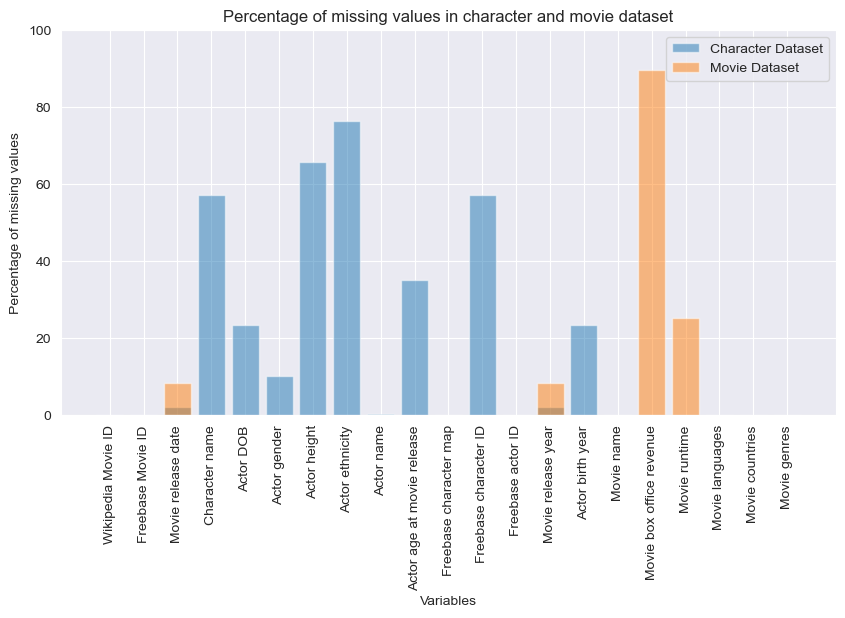

In [652]:
# Calculate percentage of missing values for each attribute
character_nan_percentages = character_metadata.isna().mean() * 100
movie_nan_percentages = movie_metadata.isna().mean() * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the character dataset NaN percentages
ax.bar(character_nan_percentages.index, character_nan_percentages, label='Character Dataset', alpha=0.5)

# Plot the movie dataset NaN percentages
ax.bar(movie_nan_percentages.index, movie_nan_percentages, label='Movie Dataset', alpha=0.5)

ax.set_ylim(0,100)
ax.set_xlabel('Variables')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of missing values in character and movie dataset')
ax.legend()
plt.xticks(rotation=90)
plt.show()

As we can see, there is a lot of missing values for some of the attributes. Especially 'Movie box office revenue' has a lot of missing values (around 90%), but we will try to work around this by adding more values, if possible.

Some character attributes like height and ethnicity are also missing.

## Distribution of variables in the character dataset

We now want to look at the distribution of the attributes of the characters metadata set. We divide the character dataset into male and female character dataset, and use box plots and histograms to look at the distribution on the attributes. We also perform a t-test for each of the attributes with the nul-hypothesis: there is no difference between male and female.

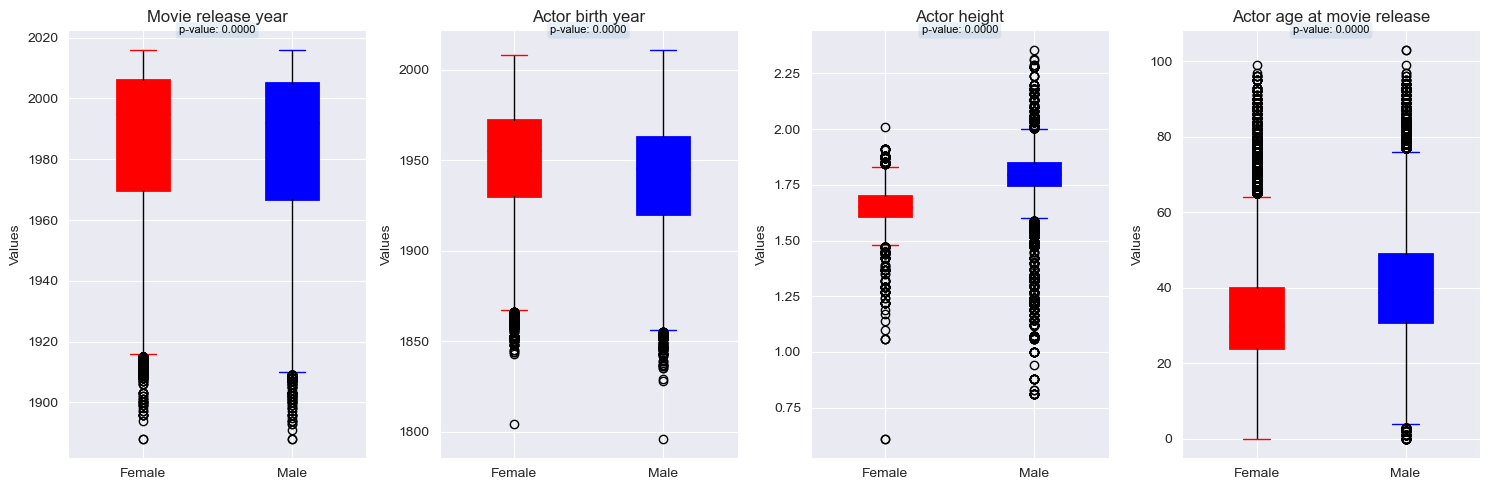

In [653]:
# Divide data into male female and male dataset
female_characters = character_metadata[character_metadata['Actor gender'] == 'F']
male_characters = character_metadata[character_metadata['Actor gender'] == 'M']

# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Extract the specific columns from the female_characters and male_characters datasets
female_data = [female_characters[var].dropna() for var in variables]
male_data = [male_characters[var].dropna() for var in variables]

# Create a figure with three subplots
_, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create box plots for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]
    
    # Create the box plots for female and male characters for the current variable
    width = 0.35  # Width of the boxes
    
    positions = [1, 2]
    box_props = dict(linewidth=2, color='black')
    median_props = dict(linewidth=2, color='black')
    cap_props = dict(color='black')
    
    # Set custom colors for the female and male box plots
    box_colors = ['red', 'blue']
    
    bp_female = ax.boxplot([female_data[i]], positions=[positions[0]], widths=width, patch_artist=True,
                           boxprops=box_props, medianprops=median_props, capprops=cap_props)
    bp_male = ax.boxplot([male_data[i]], positions=[positions[1]], widths=width, patch_artist=True,
                         boxprops=box_props, medianprops=median_props, capprops=cap_props)
    
    # Set colors for female and male box plots
    for box, color in zip([bp_female, bp_male], box_colors):
        for element in ['boxes', 'medians', 'caps']:
            plt.setp(box[element], color=color)
    
    # Perform a t-test and get the p-value
    t_stat, p_value = stats.ttest_ind(female_data[i], male_data[i])
    
    # Annotate the plot with the p-value
    ax.annotate(f'p-value: {p_value:.4f}', xy=(1.5, max(ax.get_ylim())), ha='center', va='center',
                bbox=dict(boxstyle="round", alpha=0.1),
                fontsize=8, color='black')
    
    ax.set_ylabel('Values')
    ax.set_title(variable)
    ax.set_xticks(positions)
    ax.set_xticklabels(['Female', 'Male'])

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


The first box plots show us, that more movies have been released in the more revent years. Naturally, the birth years of the actor are also more recent then. These also show us, that there is a significant difference in **Movie release year** and **Actor birth year** for male and female actors, where female actors are more represented in recent years. We might want to log-transform these attributes, if they are used in further analysis.

The height attribute shows that there is significant difference between the height of male and female, which makes sense, since men are naturally taller than woman.

The last box plot shows us, that there is a significant difference in the **Actor age at movie release** for male and female actors. It indicates, that female actors generally are younger than male actors in movie.

We also look at the distributions with a histogram:

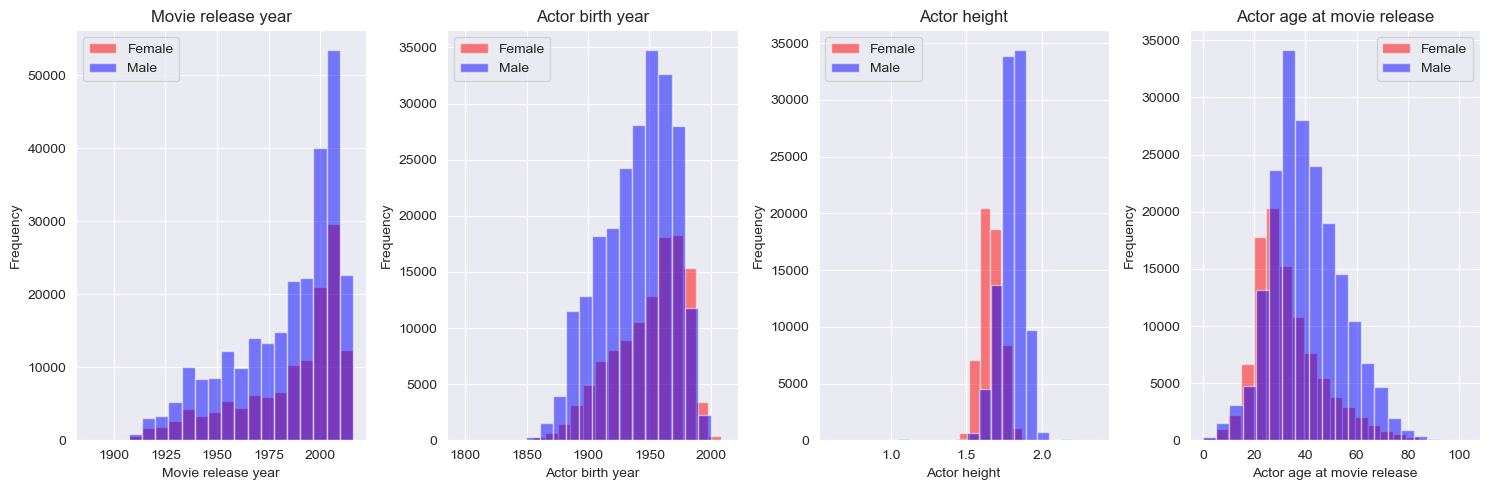

In [654]:
# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    female_data = female_characters[variable].dropna()
    male_data = male_characters[variable].dropna()

    ax.hist(female_data, bins=20, alpha=0.5, color='red', label='Female')
    ax.hist(male_data, bins=20, alpha=0.5, color='blue', label='Male')

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)
    ax.legend()

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


The histogram backs up the claims made from the box plots.

### Explore 'Actor age at movie release'

To explore the statistical difference further, we look at the attribute **Actor age at movie release** throughout all the years for female and male characters.

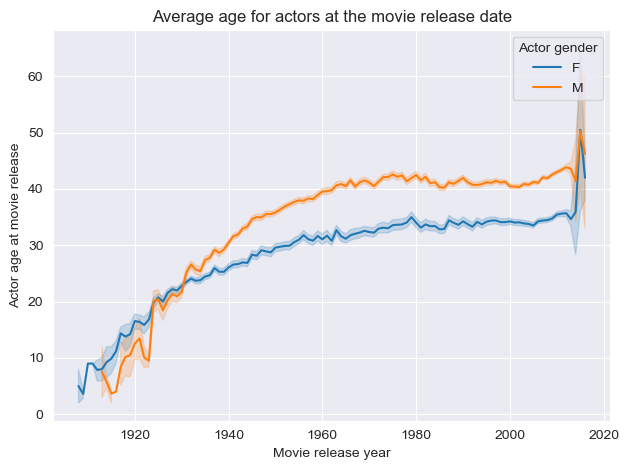

In [655]:
# Remove NaNs from relevant columns
character_metadata_nona = character_metadata[['Movie release year', 'Actor age at movie release', 'Actor gender']].dropna()
sns.lineplot(x='Movie release year', y='Actor age at movie release', data=character_metadata_nona, hue="Actor gender", err_style="band")

plt.title('Average age for actors at the movie release date')
plt.xlabel('Movie release year')
plt.ylabel('Actor age at movie release')
plt.tight_layout()
plt.show()


The plot is very strange up until around 1930. It seems that actors are very young (20 years or younger on average).

However, the plot shows that female actors are significantly younger than male actors from around year 1930 and forward.

##  Distribution of variables in the movies dataset

In [656]:
numerical_variables = ['Movie box office revenue', 'Movie runtime', 'Movie release year']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


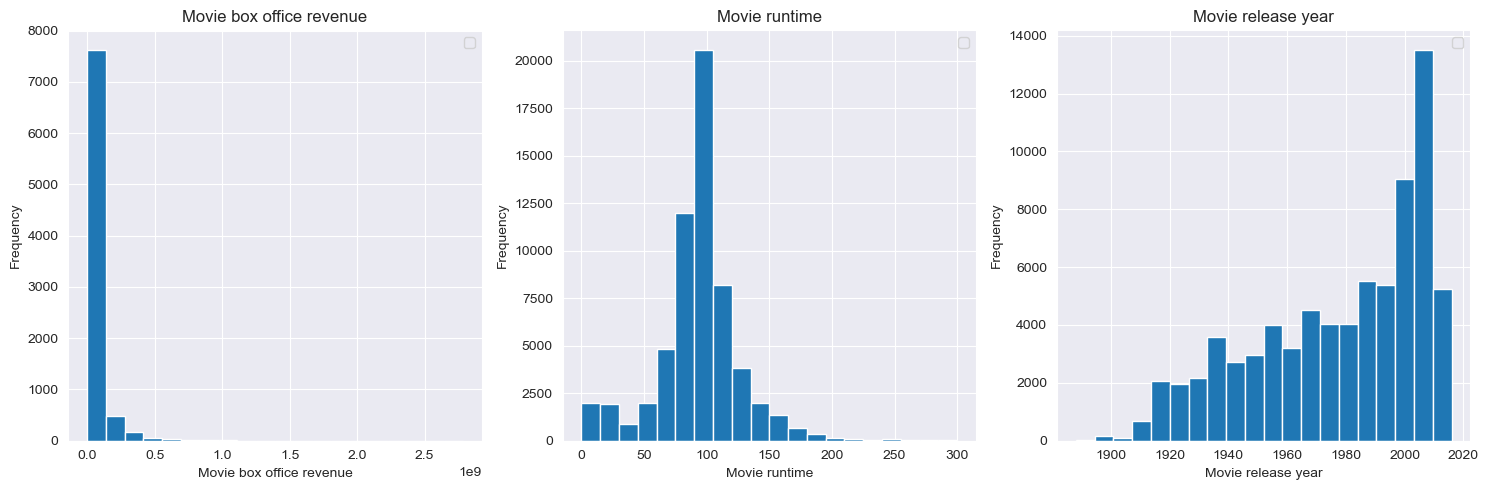

In [657]:
# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(numerical_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    data = movie_metadata[variable].dropna()

    ax.hist(data, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)
    ax.legend()

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

The plots show, that **Movie box office** has a highly right skewed distribution, also called a power law. We would need to transform this  attribute for further analysis.

The variable **Movie runtime* seem fairly normally distributed. The variable **Movie release year** is left skewed, so we will also try to apply a log transform to this.

In [658]:
movie_metadata['log Movie box office revenue'] = np.log(movie_metadata['Movie box office revenue'])

movie_metadata['log Movie release year'] = np.log(movie_metadata['Movie release year'])
character_metadata['log Movie release year'] = np.log(character_metadata['Movie release year'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


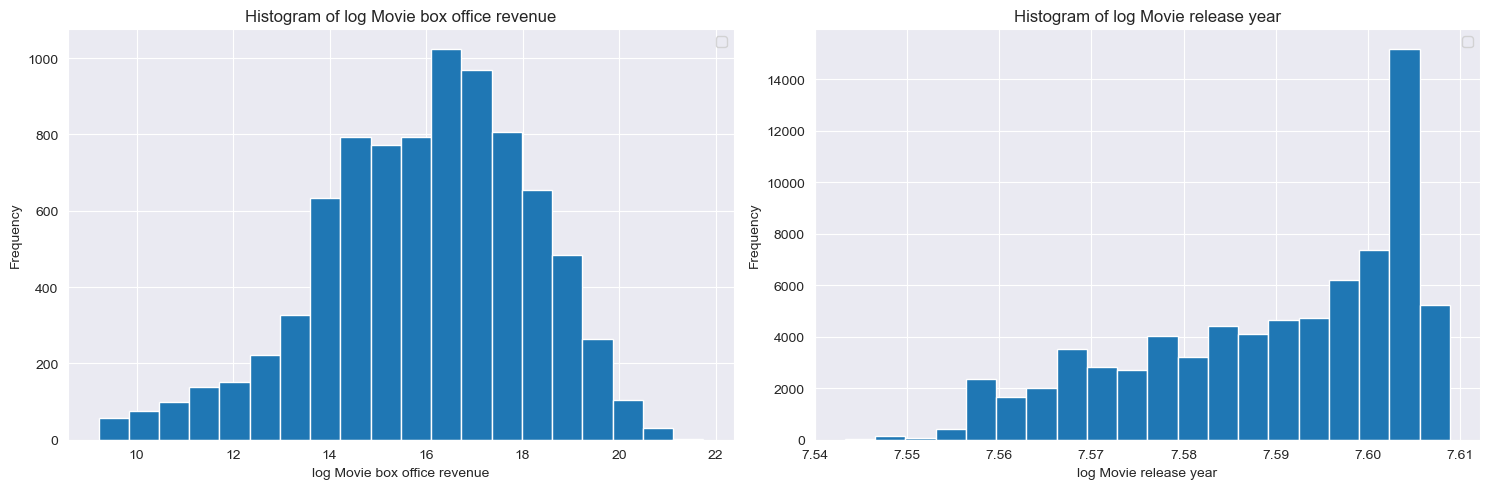

In [659]:
log_variables = ['log Movie box office revenue', 'log Movie release year']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(log_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    data = movie_metadata[variable].dropna()

    ax.hist(data, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of '+variable)
    ax.legend()

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

After the log transform, **Movie box office revenue** is fairly normally distributed, but the log transform didn't do much for **Movie release year**, so we will keep this as it is.

### Categorical values

Let us take a look at the categorical values.

In [660]:
movie_metadata[['Movie genres', 'Movie languages', 'Movie countries']].head()

,Movie genres,Movie languages,Movie countries
0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
1,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
2,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}"
3,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}"
4,"{""/m/07s9rl0"": ""Drama""}","{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}"


We convert all the values for consistency and check all unique values.

In [661]:
# Function to extract genre names without Freebase codes
def extract_genre_names(genre_dict):
    genre_names = []
    for code, name in genre_dict.items():
        genre_names.append(name)
    return ", ".join(genre_names)

# Clean the "Movie genres" column
movie_metadata["Movie genres"] = movie_metadata["Movie genres"].apply(eval)  # Convert string representation of dictionary to actual dictionary
movie_metadata["Movie genres"] = movie_metadata["Movie genres"].apply(extract_genre_names)

# Clean the "Movie languages" column (assuming similar structure to genres column)
movie_metadata["Movie languages"] = movie_metadata["Movie languages"].apply(eval)
movie_metadata["Movie languages"] = movie_metadata["Movie languages"].apply(lambda x: ", ".join(x.values()))

# Clean the "Movie countries" column (assuming similar structure to genres column)
movie_metadata["Movie countries"] = movie_metadata["Movie countries"].apply(eval)
movie_metadata["Movie countries"] = movie_metadata["Movie countries"].apply(lambda x: ", ".join(x.values()))

In [662]:
genres = movie_metadata['Movie genres'].unique()

print(f"There are {len(genres)} different combinations genres.\n")
print(genres)

There are 23817 different combinations genres.

['Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western'
 'Mystery, Biographical film, Drama, Crime Drama' 'Crime Fiction, Drama'
 ... 'Crime Fiction, Thriller, Comedy, Supernatural'
 'Sports, Crime Fiction, Action, Drama'
 'Science Fiction, Japanese Movies, Adventure, Animation, Short Film, Anime, Drama']


In [663]:
languages = movie_metadata['Movie languages'].unique()

print(f"There are {len(languages)} different combinations languages.\n")
print(languages)

There are 1817 different combinations languages.

['English Language' 'Norwegian Language' 'German Language' ...
 'Hindi Language, Standard Tibetan, English Language'
 'Spanish Language, German Language, English Language, Hungarian language'
 'Italian Language, English Language, Norwegian Language']


In [664]:
countries = movie_metadata['Movie countries'].unique()

print(f"There are {len(countries)} different combinations of countries.\n")
print(countries)

There are 2124 different combinations of countries.

['United States of America' 'Norway' 'United Kingdom' ...
 'France, Switzerland, Algeria, Germany'
 'Kingdom of Great Britain, Japan, England, United Kingdom, Germany'
 'Switzerland, Italy, West Germany, German Democratic Republic']


## Further exploration

### Gender representation in movies

We now want to further analyse our data by exploring the difference in representation of female and male actors in movies. We begin by counting the number of female and male actor in movies throughout the years.

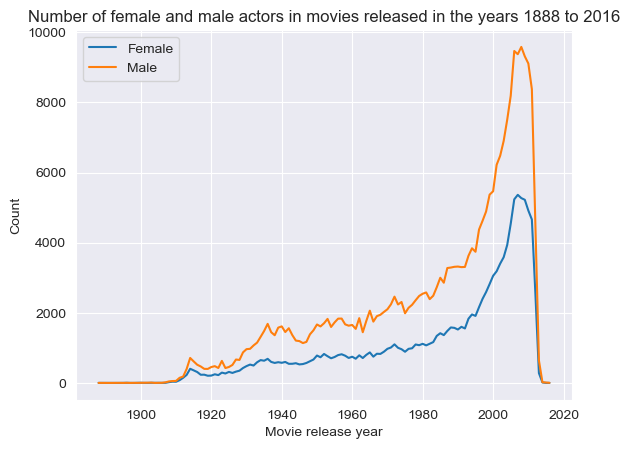

In [665]:
# Count
no_females = female_characters.groupby('Movie release year').size()
no_males = male_characters.groupby('Movie release year').size()

plt.plot(no_females)
plt.plot(no_males)
plt.title('Number of female and male actors in movies released in the years 1888 to 2016')
plt.xlabel('Movie release year')
plt.ylabel('Count')
plt.legend(['Female', 'Male'])
plt.show()

As we can see, there are generally fewer female actors in movies than male actors.

Next, we will explore the percentage of female characters in movies throughout the years. Firstly, we calculate the percentage of females for each movie and then take the average over each year. We then make a linear regression to see, if there is a change of percentage of female actors in movies over the years.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.273
Model:                                      OLS   Adj. R-squared:                  0.266
Method:                           Least Squares   F-statistic:                     44.59
Date:                          Fri, 17 Nov 2023   Prob (F-statistic):           8.17e-10
Time:                                  16:42:14   Log-Likelihood:                -456.54
No. Observations:                           121   AIC:                             917.1
Df Residuals:                               119   BIC:                             922.7
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

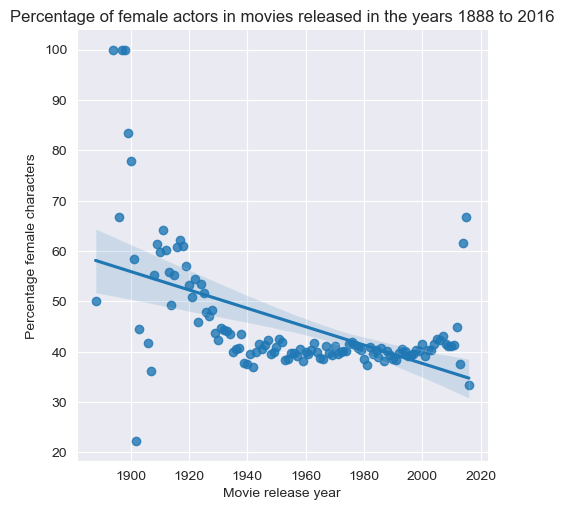

In [666]:
# Count number of female in each movie
female_count = female_characters.groupby('Wikipedia Movie ID').size()
male_count = male_characters.groupby('Wikipedia Movie ID').size()

# Ensure that all Wikipedia Movie IDs in 'female_count' are represented in 'male_count'
# Fill missing values with 0
male_count = male_count.reindex(female_count.index, fill_value=0)

# Calculate the percentage of female characters
percentage_female = (female_count / (female_count + male_count)) * 100

# Reset the index to have 'Wikipedia Movie ID' as a column
percentage_female = percentage_female.reset_index()

# Rename the columns for clarity
percentage_female.columns = ['Wikipedia Movie ID', 'Percentage female characters']

# Merge dataframes
percentage_female_with_year = pd.merge(percentage_female, movie_metadata, on='Wikipedia Movie ID', how='left')

# Calculate female percentage pr. year and make into a data frame with column 'Movie release year' and 'Percentage female characters'
percentage_female_per_year = percentage_female_with_year.groupby('Movie release year')['Percentage female characters'].mean()
percentage_female_per_year = percentage_female_per_year.reset_index(name="Percentage female characters")
percentage_female_per_year['Movie release year'] = pd.to_numeric(percentage_female_per_year['Movie release year'], errors='coerce').astype(float)

# Drop missing values
percentage_female_per_year = percentage_female_per_year.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year)

# Perform linear regression
X = percentage_female_per_year['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female actors in movies released in the years 1888 to 2016')
plt.show()

The plot and linear regression indicates, that there is a significant decline of female characters over the years. But looking at the plot, the ends have a very high variance. Let us take a look at the count of movies over the years.

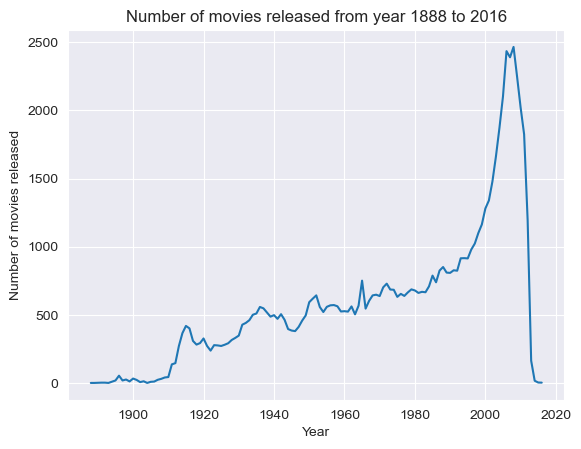

In [667]:
no_movies = movie_metadata.groupby('Movie release year').size()
plt.plot(no_movies)
plt.title('Number of movies released from year 1888 to 2016')
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.show()

Since there isn't a lot of movies and the variance is very height in the 'end' years, we look at the progression of female characters from year 1940 to 2012.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.078
Model:                                      OLS   Adj. R-squared:                  0.065
Method:                           Least Squares   F-statistic:                     5.978
Date:                          Fri, 17 Nov 2023   Prob (F-statistic):             0.0170
Time:                                  16:42:15   Log-Likelihood:                -124.75
No. Observations:                            73   AIC:                             253.5
Df Residuals:                                71   BIC:                             258.1
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

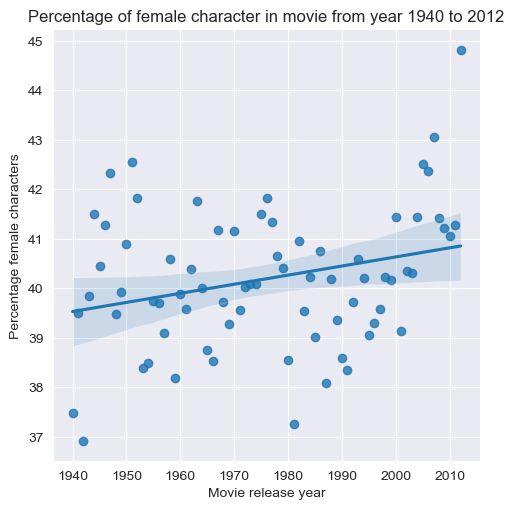

In [668]:
condition = (percentage_female_per_year['Movie release year'] < 1940) | (percentage_female_per_year['Movie release year'] > 2012)
percentage_female_per_year_filtered = percentage_female_per_year
percentage_female_per_year_filtered.loc[condition, 'Movie release year'] = np.nan
percentage_female_per_year_filtered = percentage_female_per_year_filtered.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year_filtered)

# Perform linear regression
X = percentage_female_per_year_filtered['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year_filtered["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female character in movie from year 1940 to 2012')
plt.show()

The linear regression above indicates, that there is no decline, but rather an incline in female characters. However, the p-value = 0.017, så there the incline is not significant with a .05 significance level.

### Gender's affect on box office revenue

We will now see if percentage of female characters have a significant correlation with box office revenue. We will keep in mind, that we only have box office revenue for around 10% of the movies. However, this is still 8401 movies, so we decide to use this attribute anyway.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     log Movie box office revenue   R-squared:                       0.018
Model:                                      OLS   Adj. R-squared:                  0.018
Method:                           Least Squares   F-statistic:                     146.5
Date:                          Fri, 17 Nov 2023   Prob (F-statistic):           2.03e-33
Time:                                  16:42:16   Log-Likelihood:                -16886.
No. Observations:                          7779   AIC:                         3.378e+04
Df Residuals:                              7777   BIC:                         3.379e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

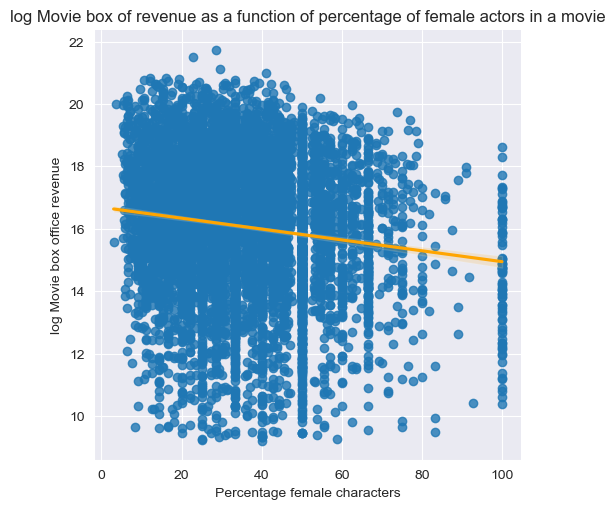

In [669]:
# Define dataframe with 'log Movie box office revenue' and 'Percentage female characters'
percentage_female_with_log_rev = percentage_female_with_year[['log Movie box office revenue', 'Percentage female characters']].dropna()

# Create a scatterplot with a regression line
sns.lmplot(x="Percentage female characters", y="log Movie box office revenue", data=percentage_female_with_log_rev, line_kws={'color': 'orange'})

# Perform linear regression
X = percentage_female_with_log_rev["Percentage female characters"]
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_with_log_rev["log Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('log Movie box of revenue as a function of percentage of female actors in a movie')
plt.show()


The plot and linear regression indicates, that there is a significant decline in box office revenue, as the percentage of female characters increases.


# Enriching data
#### 1. Adding data from www.themoviedb.org (TMDB)


In this section we are going to be using the API of www.themoviedb.org (TMDB) to populate the existing dataframe with more information about the movie. The script (TMDB_v1) will query the website using the movie name to find the closest match based on the movie's release date. If no match is found, it skips the movie and moves on to the next one.

This 1. step is adding a lot of different data from TMDB. The most important features are the:
- TMDB ID           (unique identifier for the movie, which can be used to further enrich the data)
- TMDB vote average (average movie rating)
- TMDB vote count   (how many votes were cast)

Furthermore, TMDB_v1 also adds the:
- original language, original title, release date, title
- overview (summary)
- popularity (metric composed of many different variables indicating a movies lifetime popularity)


This script was run separately in another file in /utils/add_TMDB_movie_metadata_v1.py as it needed to be executed in  several installments over several sessions, since the API was limited by 40 requests/second. (this version contains slightly different path variations).

In [2]:
load_dotenv() # Loads .env files aka. the TMDB_API_KEY

headers_movie_metadata = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie name", "Movie release date",
                          "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries",
                          "Movie genres"]
movie_metadata = pd.read_csv('data/movie.metadata.tsv', sep="\t", names=headers_movie_metadata)


# Load API key
TMDB_API_KEY = os.environ.get("TMDB_API_KEY")
tmdb.API_KEY = TMDB_API_KEY
tmdb.REQUESTS_TIMEOUT = 5  # Seconds, for both connect and read

# Create a list to save progress
saved_progress = []

# Determine where to resume
start_index = 28000

# Progress file that can be used to resume
#saved_progress = pd.read_json('progress.json')['index'].tolist()
#start_index = saved_progress[-1] + 1  # Start from the next index

# Create a DataFrame to store the data
movie_metadata_TMDB = movie_metadata.copy()

for index, row in tqdm(movie_metadata_TMDB.iterrows(), total=len(movie_metadata_TMDB), desc="Processing"): # Wraps for loop in progress bar.
    
    # Skip previously processed indices - Commented out in favor of manual start_index
    #if index in saved_progress:
    #    continue
    if index < start_index:
        continue
    try:
        if not pd.isna(row["Movie release date"]):
            search = tmdb.Search()
            response = search.movie(query=row["Movie name"])

            # Convert dataframe release date to datetime
            movie_release_date_str = row["Movie release date"]
            if len(movie_release_date_str) == 4:  # Handle "YYYY" format
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y").date()
            elif len(movie_release_date_str) == 7:  # Handle "YYYY-DD" format
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y-%m").date()
            else:  # Assume it's in the format "YYYY-MM-DD"
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y-%m-%d").date()

            # Handle if release_date is empty.
            date_list_converted = [datetime.strptime(each_date['release_date'], "%Y-%m-%d").date() for each_date in
                                   search.results if each_date.get('release_date')]

            # Create list of differences in time
            differences = [abs(movie_release_date - each_date) for each_date in date_list_converted]
            
            # If differences are empty = skip
            if not differences:
                continue
            minimum_index = differences.index(min(differences))  # Index of the closest match
            match = search.results[minimum_index]
            # print(f"Closest match: {match['title']} (Release Date: {match['release_date']})")

            # Add info in dataframe about the movie
            movie_metadata_TMDB.loc[index, 'TMDB_id'] = match['id']
            movie_metadata_TMDB.loc[index, 'TMDB_original_language'] = match['original_language']
            movie_metadata_TMDB.loc[index, 'TMDB_original_title'] = match['original_title']
            movie_metadata_TMDB.loc[index, 'TMDB_overview'] = match['overview']
            movie_metadata_TMDB.loc[index, 'TMDB_popularity'] = match['popularity']
            movie_metadata_TMDB.loc[index, 'TMDB_release_date'] = match['release_date']
            movie_metadata_TMDB.loc[index, 'TMDB_title'] = match['title']
            movie_metadata_TMDB.loc[index, 'TMDB_vote_average'] = match['vote_average']
            movie_metadata_TMDB.loc[index, 'TMDB_vote_count'] = match['vote_count']
            
            # Save the index as progress
            saved_progress.append(index)

            # Save progress periodically (in case of interruption)
            if index % 50 == 0:
                progress_df = pd.DataFrame({'index': saved_progress})
                progress_df.to_json('progress.json')
                movie_metadata_TMDB.to_csv('movie_metadata_TMDB.csv', index=False)

    except Exception as e:
        print(f"Error at index {index}: {str(e)}")

# Save final progress
progress_df = pd.DataFrame({'index': saved_progress})
progress_df.to_json('progress.json')

# Save your final DataFrame
#movie_metadata_TMDB.to_csv('modified_data/movie_metadata_TMDB.csv') # Commented out to not overwrite existing file with blank data

Processing: 100%|██████████| 81741/81741 [00:03<00:00, 20657.45it/s]


We are now going to see how many rows of data were populated in the enriching. 
The TMDB_ID is a good indicator for this.

In [3]:
df = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
print(f"Added TMDB ID to {df['TMDB_id'].count()} movies. Total movies: {df['Wikipedia Movie ID'].count()}. \n Percentage populated: {round(df['TMDB_id'].count()/df['Wikipedia Movie ID'].count()*100,2)}%")


Added TMDB ID to 68944 movies. Total movies: 81741. 
 Percentage populated: 84.34%


#### 2. Adding Movie Revenue
The script above (TMDB_v1) used a 'query' method for TMDB, we are now going to be using the 'Movies' method to collect further data about the movies (TMDB_v2). 
Since many of the movies are missing their revenue, TMDB might have that information for some movies.

The same basis as for TMDB_v1 is used to collect data. The data being collected is: 
- revenue, budget, runtime, IMDB-id and genres.

While our original dataset includes movie genres, it's always good to have more information and the two might differ for an interesting analysis further on.

Like TMDB_v1, TMDB_v2 was run separately in another file: /utils/add_TMDB_movie_metadata_V2.py as it needed to be run on several occasions since the API is limited.

In [ ]:
load_dotenv()

# Load v1, which was created in TMDB_v1 above
movie_metadata_TMDB = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
movie_metadata_TMDB = movie_metadata_TMDB.dropna(subset=['TMDB_id']) # Drop all columns, which don't contain an id

TMDB_API_KEY = os.environ.get("TMDB_API_KEY")
tmdb.API_KEY = TMDB_API_KEY
tmdb.REQUESTS_TIMEOUT = 5  

saved_progress = []
start_index = 35000

#saved_progress = pd.read_json('progress_v2.json')['index'].tolist()
#start_index = saved_progress[-1] + 1  # Start from the next index

for index, row in tqdm(movie_metadata_TMDB.iterrows(), total=len(movie_metadata_TMDB), desc="Processing"): 
    if index < start_index:
        continue
    try:
        movie = tmdb.Movies(row['TMDB_id']) # The "Movies" method is used with the TMDB_id of the movie
        movie_info = movie.info()
        
        # The dataframe is populated with the data: runtime, revenue, budget and IMDB_id.
        movie_metadata_TMDB.loc[index,'TMDB_runtime'] = movie_info['runtime']
        movie_metadata_TMDB.loc[index,'TMDB_revenue'] = movie_info['revenue']
        movie_metadata_TMDB.loc[index,'TMDB_budget'] = movie_info['budget']
        movie_metadata_TMDB.loc[index,'TMDB_IMDB_id'] = movie_info['imdb_id']

        # Convert list of genres to a string representation for adding the values easily to the df
        genres_str = ', '.join([genre['name'] for genre in movie_info['genres']])
        # Assign values to DataFrame
        movie_metadata_TMDB.loc[index, 'TMDB_genres'] = genres_str
        
        saved_progress.append(index)

        if index % 50 == 0:
            progress_df = pd.DataFrame({'index': saved_progress})
            progress_df.to_json('progress_v2.json')
            movie_metadata_TMDB.to_csv('movie_metadata_TMDB_v2.csv', index=False)

    except Exception as e:
        print(f"Error at index {index}: {str(e)}")

progress_df = pd.DataFrame({'index': saved_progress})
progress_df.to_json('progress_v2.json')

#movie_metadata_TMDB.to_csv('modified_data/movie_metadata_TMDB_v2_DONE.csv', index=False) # commented out to not overwrite existing data

After data collection we now need to merge the datasets created by TMDB_v2 and TMDB_v1. This merge is going to create a dataset called TMDB_v3. This is done to make sure we have a dataset that contains all the data and not only movies where a 'TMDB_id' is present as in TMDB_v2.


In [35]:
# The two datasets are loaded
movie_metadata_v2 = pd.read_csv('modified_data/movie_metadata_TMDB_v2.csv')
movie_metadata = pd.read_csv('modified_data/movie_metadata_TMDB.csv',index_col=0)

# Datasets are inspected beforehand
display(movie_metadata)
display(movie_metadata_v2)

# Datasets are merged with a left join on movie_metadata (the dataset we want to populate)
merged_df = pd.merge(movie_metadata,movie_metadata_v2,how='left')

display(merged_df) # The merged dataset is displayed and a successful merge is confirmed

merged_df.to_csv("modified_data/movie_metadata_TMDB_v3.csv",index=False) # The merged dataset is saved as *_V3 


C:\Users\gusta\AppData\Local\Temp\ipykernel_9244\688652978.py:2: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_v2 = pd.read_csv('modified_data/movie_metadata_TMDB_v2.csv')


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,TMDB_original_language,TMDB_original_title,TMDB_overview,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,en,Ghosts of Mars,"In 2176, a Martian police unit is sent to pick...",17.280,2001-08-24,Ghosts of Mars,5.123,980.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,en,Getting Away with Murder: The JonBenét Ramsey ...,Dramatization of the story behind the murder o...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,no,Brun bitter,A stolen bicycle case ends with drunken detect...,0.600,1988-11-17,Hair of the Dog,0.000,0.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,en,White of the Eye,"In a wealthy and isolated desert community, a ...",7.336,1987-06-19,White of the Eye,5.742,64.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,de,Die flambierte Frau,"Eva, an upper-class housewife, frustratedly le...",2.397,1983-05-11,A Woman in Flames,5.300,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,en,Mermaids: The Body Found,A story that imagines how these real-world phe...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,en,Knucklehead,A fight promoter deeply in debt to his crooked...,9.789,2010-10-22,Knucklehead,5.500,50.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,en,Another Nice Mess,Nixon and Agnew played as Laurel and Hardy.,1.960,1972-08-23,Another Nice Mess,0.000,0.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,...,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count,TMDB_runtime,TMDB_revenue,TMDB_budget,TMDB_IMDB_id,TMDB_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,...,17.280,2001-08-24,Ghosts of Mars,5.123,980.0,98.0,14010832.0,28000000.0,tt0228333,"Action, Horror, Science Fiction"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0,60.0,NaN,0.0,tt0245916,"Drama, Crime"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,...,0.600,1988-11-17,Hair of the Dog,0.000,0.0,83.0,NaN,0.0,tt0094806,"Mystery, Crime, Drama"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,...,7.336,1987-06-19,White of the Eye,5.742,64.0,111.0,NaN,0.0,tt0094320,"Horror, Thriller"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,...,2.397,1983-05-11,A Woman in Flames,5.300,13.0,106.0,NaN,0.0,tt0083949,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68939,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/06bnz"": ""Russia""}","{""/m/01z02hx"": ""Sports"", ""/m/0lsxr"": ""Crime Fi...",56525.0,...,4.421,2007-10-18,Revenge,5.607,28.0,NaN,NaN,NaN,NaN,NaN
68940,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0,NaN,NaN,NaN,NaN,NaN
68941,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,...,9.789,2010-10-22,Knucklehead,5.500,50.0,NaN,NaN,NaN,NaN,NaN
68942,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,...,1.960,1972-08-23,Another Nice Mess,0.000,0.0,NaN,NaN,NaN,NaN,NaN


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,...,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count,TMDB_runtime,TMDB_revenue,TMDB_budget,TMDB_IMDB_id,TMDB_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,...,17.280,2001-08-24,Ghosts of Mars,5.123,980.0,98.0,14010832.0,28000000.0,tt0228333,"Action, Horror, Science Fiction"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0,60.0,NaN,0.0,tt0245916,"Drama, Crime"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,...,0.600,1988-11-17,Hair of the Dog,0.000,0.0,83.0,NaN,0.0,tt0094806,"Mystery, Crime, Drama"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,...,7.336,1987-06-19,White of the Eye,5.742,64.0,111.0,NaN,0.0,tt0094320,"Horror, Thriller"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,...,2.397,1983-05-11,A Woman in Flames,5.300,13.0,106.0,NaN,0.0,tt0083949,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0,NaN,NaN,NaN,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,...,9.789,2010-10-22,Knucklehead,5.500,50.0,NaN,NaN,NaN,NaN,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,...,1.960,1972-08-23,Another Nice Mess,0.000,0.0,NaN,NaN,NaN,NaN,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 2.1 Combining revenue columns into a single one.
In this section we're going to analyse the data collected, combine the 'original revenue' and 'TMDB_revenue' columns and save another version of the dataset, which contains the final data for the analysis.

In [39]:
movie_metadata_v3 = pd.read_csv('modified_data/movie_metadata_TMDB_v3.csv')

# We will now compare the two columns containing the 'original revenue' and 'TMDB_revenue', where either column is NaN but not both at the same time. This will show how they can complement each other.
filtered_df = movie_metadata_v3[(movie_metadata_v3['Movie box office revenue'].isna() | movie_metadata_v3['TMDB_revenue'].isna()) & ~(movie_metadata_v3['Movie box office revenue'].isna() & movie_metadata_v3['TMDB_revenue'].isna())]
display(filtered_df[['Movie name','Movie box office revenue','TMDB_revenue']])

# Combining the two revenue columns into one using combine_first which combines two df objects by filling null values in one df with non-null from the other df 
movie_metadata_v3['Movie box office revenue enriched'] = movie_metadata_v3['Movie box office revenue'].combine_first(movie_metadata_v3['TMDB_revenue'])

# Comparing old dataset to new
tmdb_v3_revenue = movie_metadata_v3['Movie box office revenue enriched'].isna().sum()
tmdb_v1 = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
tmdb_v1_revenue = tmdb_v1['Movie box office revenue'].isna().sum()

print("Original revenue NaN:", tmdb_v1_revenue)
print("New revenue NaN:",tmdb_v3_revenue)
print("Difference", tmdb_v1_revenue-tmdb_v3_revenue)

# Removing the two columns that combined into one column
movie_metadata_v4 = movie_metadata_v3.drop(columns=['Movie box office revenue','TMDB_revenue'])

display(movie_metadata_v4)

movie_metadata_v4.to_csv('modified_data/movie_metadata_TMDB_FINAL.csv',index=False) # Saving the final version of the modified dataset

C:\Users\gusta\AppData\Local\Temp\ipykernel_9244\2197755176.py:4: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_v3 = pd.read_csv('modified_data/movie_metadata_TMDB_v3.csv')


,Movie name,Movie box office revenue,TMDB_revenue
36,They Knew What They Wanted,932000.0,NaN
47,Daddy and Them,NaN,6718.0
53,Rudo y Cursi,11091868.0,NaN
57,Innocence,NaN,37598.0
60,The Great New Wonderful,172055.0,NaN
...,...,...,...
81695,Coming to America,288752301.0,NaN
81720,Spaced Invaders,15369573.0,NaN
81725,State and Main,6944471.0,NaN
81726,Guilty as Sin,22886222.0,NaN


Original revenue NaN: 73340
New revenue NaN: 71723
Difference 1617


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,TMDB_original_language,...,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count,TMDB_runtime,TMDB_budget,TMDB_IMDB_id,TMDB_genres,Movie box office revenue enriched
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,en,...,17.280,2001-08-24,Ghosts of Mars,5.123,980.0,98.0,28000000.0,tt0228333,"Action, Horror, Science Fiction",14010832.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,en,...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0,60.0,0.0,tt0245916,"Drama, Crime",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,no,...,0.600,1988-11-17,Hair of the Dog,0.000,0.0,83.0,0.0,tt0094806,"Mystery, Crime, Drama",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,en,...,7.336,1987-06-19,White of the Eye,5.742,64.0,111.0,0.0,tt0094320,"Horror, Thriller",NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,de,...,2.397,1983-05-11,A Woman in Flames,5.300,13.0,106.0,0.0,tt0083949,Drama,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,en,...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0,NaN,NaN,NaN,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,en,...,9.789,2010-10-22,Knucklehead,5.500,50.0,NaN,NaN,NaN,NaN,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,en,...,1.960,1972-08-23,Another Nice Mess,0.000,0.0,NaN,NaN,NaN,NaN,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems like the original dataset contained much of the information on the different movie revenues available.
However, for 1617 movies the revenue was added, which is quite a lot in the context of ~40000 movies with plot summaries. 
This will only further enhance the data analysis process.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Natural language processing

In this section we have attempted to process the summaries in a way that could cluster the movies depending on words used in the summaries themselves. 
Some of the processes take a long time to run so in the code there are multiple data sets or lists being saved as files to avoid running computational heavy tasks multiple times. 

In [6]:
# CHECK BEFORE RUNNING!!!
flag_preprocess = True # If false, skip the generation of a preprocessed corpus
flag_cluster_labels_kmeans = False # Run the kmeans algorithm and return labels for every movie 
flag_movie_cluster = False # If false, stop overwrite of a cluster matrix
flag_best_k = False # Runs a simulation to make silhouettes of a set number of k's for kmeans algorithm 
flag_best_component = False # Runs test to find a lower bound for amount of components

### Load and filter movie data

In [7]:
# Read main data file 'movie_metadata_TMDB.csv'
movie_metadata = pd.read_csv('modified_data/movie_metadata_TMDB_FINAL.csv')

# Filter rows with no values in the box office and voting columns
movie_metadata_filtered = movie_metadata.dropna(subset=['TMDB_vote_average', 'Movie box office revenue enriched'])

# Extract movie IDs from the filtered DataFrame
movie_ids_filtered = movie_metadata_filtered['Wikipedia Movie ID'].tolist()

# Read file 'plot_summaries.txt'
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    summaries = file.readlines()

# Filter summaries based on movie IDs that match with filtered_movie_ids
filtered_summaries = [summary for summary in summaries if int(summary.split()[0]) in movie_ids_filtered]

# Extract movie IDs for the films that with be used
movie_ids = [int(summary.split()[0]) for summary in filtered_summaries]

/var/folders/z6/0dqw2m7n37l5vjqcv_822tdr0000gn/T/ipykernel_33365/1350669241.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('modified_data/movie_metadata_TMDB_FINAL.csv')


In [4]:
# Work only on a portion of the data
filtered_summaries = filtered_summaries[:int(len(filtered_summaries)*0.01)]
movie_ids = movie_ids[:int(len(movie_ids)*0.01)]

### Preprocess the summaries 

In [107]:
# Preprocess the summaries and stemming
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Convert to lowercase and tokenize
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Apply stemming and lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]
    return ' '.join(words)


# Remove names form the summaries
nlp = spacy.load("en_core_web_sm")

def remove_names(text): 
    doc = nlp(text)
    filtered_text = []
    for token in doc:
        if token.ent_type_ != "PERSON":
            filtered_text.append(token.text)
    return " ".join(filtered_text)

In [108]:
# Preprocess the summaries 
preprocessed_summaries = []
if flag_preprocess:
    for summary in tqdm(filtered_summaries, desc="Processing summaries"):
        preprocessed_summaries.append(preprocess_text(remove_names(summary.split('\t')[1])))
    
    # Save preprocessed_summaries list to a file
    with open('preprocessed_summaries.pkl', 'wb') as file:
        pickle.dump(preprocessed_summaries, file)

Processing summaries: 100%|██████████| 86/86 [00:09<00:00,  9.07it/s]


In [109]:
# Combined stemmed summaries with labels 
if flag_preprocess:
    summaries_preprocessed_dist = []
    for i in range(len(preprocessed_summaries)):
        summaries_preprocessed_dist.append({"id": movie_ids[i], "text": preprocessed_summaries[i]})
    
    # Save summaries_preprocessed_dist to a file
    with open('summaries_preprocessed_dist.json', 'w') as f:
        json.dump(summaries_preprocessed_dist, f)

# TF/IDF vectorization & kmeans

In [110]:
# Load preprocessed_summaries list from the saved file
with open('preprocessed_summaries.pkl', 'rb') as file:
    preprocessed_summaries = pickle.load(file)

In [111]:
# Convert text data into numerical features using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_summaries)

Now we will determine the optimal number of components (n_components) for dimensionality reduction using Truncated Singular Value Decomposition (Truncated SVD) by plotting the explained variance ratio against a range of specified values for n_components and identifying a point where a sufficient amount of variance is retained.

100%|██████████| 3/3 [10:44<00:00, 214.93s/it]


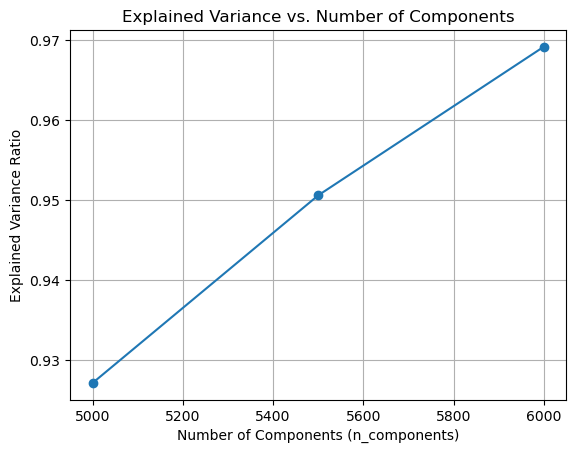

In [97]:
if flag_best_component:  
    # Specify a range of n_components to try
    components_range = np.arange(5000, 6001, 500)
    
    # List to store explained variance ratios
    explained_variances = []
    
    for n_components in tqdm(components_range):
        # Apply Truncated SVD
        svd = TruncatedSVD(n_components=n_components)
        tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
        
        # Calculate explained variance ratio
        explained_variance = np.sum(svd.explained_variance_ratio_)
        explained_variances.append(explained_variance)
    
    # Plot the explained variance ratio as a function of n_components
    plt.plot(components_range, explained_variances, marker='o')
    plt.title('Explained Variance vs. Number of Components')
    plt.xlabel('Number of Components (n_components)')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

We see that with 5500 components we get above an EVR og 95%.

In [99]:
if flag_best_component:    
    # Apply Truncated SVD for dimensionality reduction
    n_components = 5500  
    svd = TruncatedSVD(n_components=n_components)
    tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

### Finding the optimal k

In [100]:
if flag_best_k:
    silhouettes = []
    sse = []
    # Try multiple k
    for k in tqdm(range(20, 40)):
        # Cluster the data and assigne the labels
        labels = kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(tfidf_matrix_reduced) 
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(tfidf_matrix_reduced) 
        sse.append({"k": k, "sse": kmeans.inertia_})
        # Get the Silhouette score
        score = silhouette_score(tfidf_matrix_reduced, labels)
        silhouettes.append({"k": k, "score": score})

100%|██████████| 20/20 [10:34<00:00, 31.71s/it]


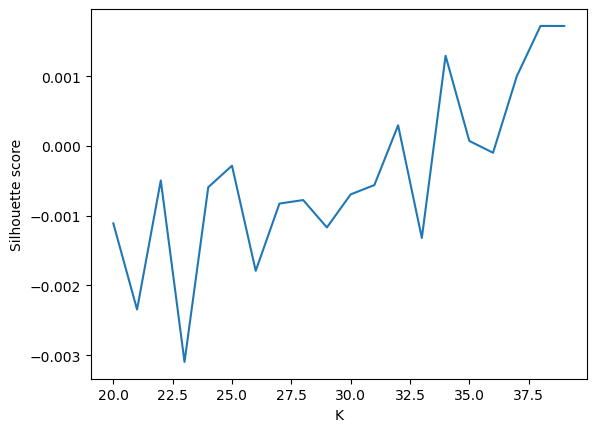

In [101]:
if flag_best_k:   
    # Convert to dataframe
    silhouettes = pd.DataFrame(silhouettes)
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(silhouettes.k, silhouettes.score)
    plt.xlabel("K")
    plt.ylabel("Silhouette score") 

Negative values... Something is off. We have not been able to identify the problem for now.

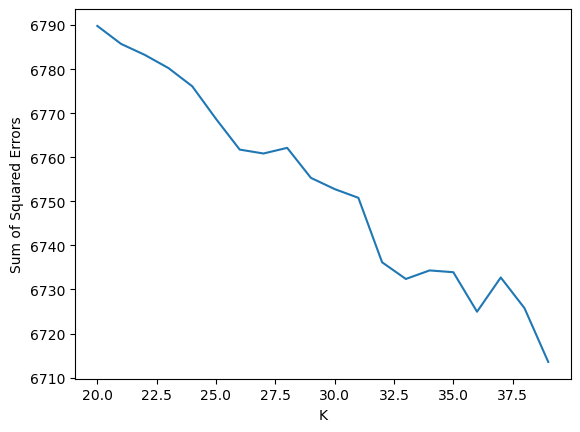

In [102]:
if flag_best_k:
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

There is no obvious "elbow" to be seen. We choose to go with 30 clusters and see what we get.

### Apply KMeans clustering 

In [118]:
# Apply KMeans clustering and return the labels for every movie 
num_clusters = 34 # k 

if flag_cluster_labels_kmeans: 
    cluster_labels = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit_predict(tfidf_matrix_reduced) # This takes quite some time...
    
    # Save cluster_labels to a file
    with open('cluster_labels.pkl', 'wb') as f:
        pickle.dump(cluster_labels, f)


In [119]:
# Load cluster_labels from a file
with open('cluster_labels.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

In [120]:
# Create a dictionary to store movie IDs and their corresponding cluster labels
movie_clusters_id = dict(zip(movie_ids, cluster_labels))

With the movies given a cluster label we make a dataframe with all the movies in the given dataframe. For easy readability the movie ids are replaced with their actual name. 

In [121]:
# Create a DataFrame to store cluster information
cluster_df = pd.DataFrame(columns=[f'Cluster {i}' for i in range(num_clusters)])

# Iterate through movie clusters and match with movie_metadata_filtered
if flag_movie_cluster:
    for movie_id, cluster_label in tqdm(movie_clusters_id.items()):
        # Find the corresponding row in movie_metadata_filtered based on Wikipedia Movie ID
        movie_row = movie_metadata_filtered[movie_metadata_filtered['Wikipedia Movie ID'] == movie_id]
        
        # Extract movie name from the row
        movie_name = movie_row['Movie name'].values[0] if not movie_row.empty else f'Movie {movie_id}'
        
        # Update cluster_df with movie name in the appropriate cluster column
        cluster_df.loc[len(cluster_df), f'Cluster {cluster_label}'] = movie_name
    
    
    # Fill NaN values with empty string for better representation
    cluster_df.fillna('', inplace=True)

100%|██████████| 7490/7490 [00:10<00:00, 688.86it/s] 


In [122]:
# Save cluster_df as CSV
if flag_movie_cluster:
    cluster_df.to_csv('clustered_movies.csv', index=True)

In [141]:
# Load cluster_df from a file
cluster_df = pd.read_csv('clustered_movies.csv')
cluster_df['Cluster 6'].sort_values().head(10)

1492               AVP: Alien vs. Predator
3081    AVPR: Aliens vs Predator - Requiem
6567                                 Alien
6322                   Alien: Resurrection
4614                   Aliens in the Attic
6381                                Alien³
1348           Attack of the 50 Foot Woman
3593                      Battle for Terra
4816                            Battleship
5468                        Chicken Little
Name: Cluster 6, dtype: object

Looking at the titles in Cluster 6 as printed above, it looks as if our method at least clusters movies about similar topics.

# Visualizing word in clusters
In the following segment we try to look at the clusters and see if there seems to be any relevant information to be found in them. 
Firstly we will visualize the clusters in "Word Clouds".

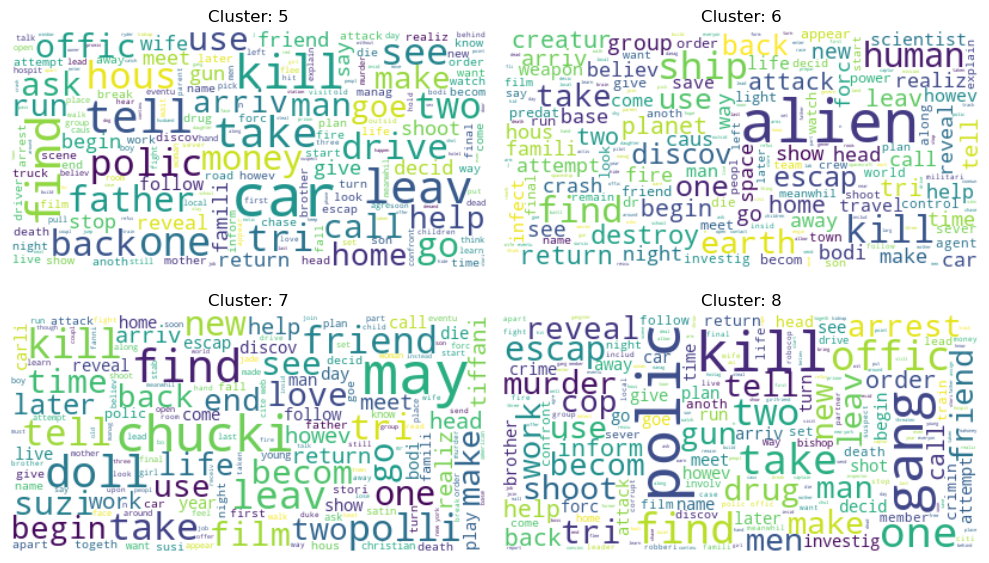

In [124]:

pic = {'cluster': cluster_labels, 'sum': preprocessed_summaries}
pic = pd.DataFrame(pic)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for k in range(5,9):
    ax = axes[(k-5) // 2, (k-5) % 2]

    # Extract data for the current cluster
    s = pic[pic.cluster == k]
    text = s['sum'].str.cat(sep=' ')

    # Generate word cloud
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)

    # Plot the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title('Cluster: {}'.format(k))
    ax.axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

We see that the 4 cluster seen here have some clear tendencies as well. Looking at Cluster 6 the bigger words, that represent more relevance, seem to fal in the same category with alien, ship, kill and earth as dominant tokens. 

### Top words in each cluster
Now we will try to sort all the words after importance to the clusters.

In [125]:
def get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer, top_n=10):
    cluster_words = {}
    terms = vectorizer.get_feature_names_out()
    
    for cluster_label in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster_label)[0]
        cluster_tfidf_scores = np.sum(tfidf_matrix[cluster_indices], axis=0)
        sorted_indices = np.argsort(cluster_tfidf_scores)[0, ::-1][:top_n]
        top_words = [terms[i] for i in sorted_indices]
        cluster_words[cluster_label] = top_words
        
    return cluster_words

# Call the function to get cluster words
cluster_words = get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer)

In [139]:
cluster_words[6][0][0][:10]

array(['alien', 'earth', 'ship', 'human', 'planet', 'kill', 'creatur',
       'spacecraft', 'crash', 'destroy'], dtype=object)

We are again looking at Cluster 6. The most relevant words seem to relate a lot to the titles we saw falling into this cluster. Aliens and space are apparently a theme for this cluster. 

In [127]:
# Dataframe for top 1000 words ranked for every cluster
cluster_words_ranked = pd.DataFrame()

for i in range(len(cluster_words)):
    cluster_words_ranked[f'{i}'] = cluster_words[i][0][0][:1000]
    
cluster_words_ranked.head(10)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,killer,father,king,school,german,car,alien,may,polic,soldier,...,plane,babi,hotel,dr,band,game,power,sean,bank,gold
1,murder,tell,henri,student,bond,polic,earth,polli,gang,zombi,...,pilot,tommi,room,patient,music,team,dr,cubbi,robberi,team
2,kill,mother,duke,high,japanes,kill,ship,chucki,cop,infect,...,flight,adopt,leav,hospit,play,player,robot,eden,robber,kill
3,polic,get,margot,teacher,war,drive,human,web,offic,armi,...,aircraft,child,find,doctor,concert,coach,batman,kill,rob,find
4,serial,home,royal,friend,american,get,planet,cite,kill,kill,...,air,becom,take,nurs,rock,play,use,island,money,train
5,detect,leav,england,class,shark,money,kill,suzi,drug,war,...,fli,pregnant,return,one,perform,footbal,kill,trevor,gang,two
6,victim,love,franc,father,marin,leav,creatur,doll,member,attack,...,passeng,famili,end,room,record,win,human,facebook,polic,leprechaun
7,ghostfac,day,love,year,kill,tell,spacecraft,friend,murder,vietnam,...,land,get,meet,help,song,basketbal,earth,find,get,tri
8,find,famili,english,get,command,hous,crash,film,investig,group,...,crash,mother,tri,medic,guitar,basebal,superman,mcglori,escap,take
9,suspect,new,musket,colleg,soviet,gun,destroy,love,one,command,...,kill,back,get,tri,musician,leagu,clone,marci,heist,citi


In [128]:
cluster_words_ranked.to_csv('cluster_words.csv', index=False, header=True)

We see that most clusters have themes that are easily identifiable. This makes sense as our method relies on clustering be similar words. 

# Rating
In the following section we will try to explore whether there is a significant different in the rating of the different clusters.

In [129]:
# List with rating and movie ID for movies with more than 20 voters
movie_ratings_cleand = movie_metadata_filtered.loc[movie_metadata_filtered['TMDB_vote_count'] > 20, ['TMDB_vote_average', 'Wikipedia Movie ID']]
movie_ratings_cleand.rename(columns = {'TMDB_vote_average': 'Rating', 'Wikipedia Movie ID': 'ID'}, inplace=True)
movie_ratings_cleand.head(10)

,Rating,ID
0,5.123,975900
7,6.600,10408933
13,7.213,171005
17,7.571,77856
21,5.200,612710
29,7.157,156558
49,7.227,261237
53,7.100,12008535
54,5.400,4951456
61,6.112,12053509


In [130]:
# Create a DataFrame from the dictionary
movie_id_clusters_df = pd.DataFrame({'ID': movie_ids,'Cluster_Label': cluster_labels})

# Merge movie_clusters_df with movie_ratings_cleand on the 'id' column
movie_id_clusters_rating_df = pd.merge(movie_id_clusters_df, movie_ratings_cleand, on='ID')
movie_id_clusters_rating_df.head(10)

,ID,Cluster_Label,Rating
0,31186339,13,7.195
1,2231378,14,6.700
2,595909,19,6.700
3,1952976,13,5.630
4,1480747,14,5.148
5,447194,13,6.600
6,12978934,3,6.444
7,8471210,0,7.457
8,1925869,33,6.648
9,5414895,13,7.100


In [135]:
# Calculate the average rating for each cluster
cluster_avg_ratings = movie_id_clusters_rating_df.groupby('Cluster_Label')['Rating'].mean().reset_index()
cluster_std_ratings = movie_id_clusters_rating_df.groupby('Cluster_Label')['Rating'].std().reset_index()

cluster_ratings_avg_std = pd.merge(cluster_avg_ratings, cluster_std_ratings, on='Cluster_Label', suffixes=('_avg', '_std')).sort_values(by='Rating_avg').reset_index(drop=True)

cluster_ratings_avg_std.head(10)

,Cluster_Label,Rating_avg,Rating_std
0,10,5.960333,0.936089
1,0,6.036667,0.695393
2,6,6.060897,0.781043
3,11,6.119532,0.733578
4,20,6.135167,0.816060
5,14,6.182725,0.911144
6,24,6.209085,0.698350
7,33,6.253926,0.833468
8,30,6.254115,0.946854
9,29,6.255852,0.806058


Text(0, 0.5, 'Rating')

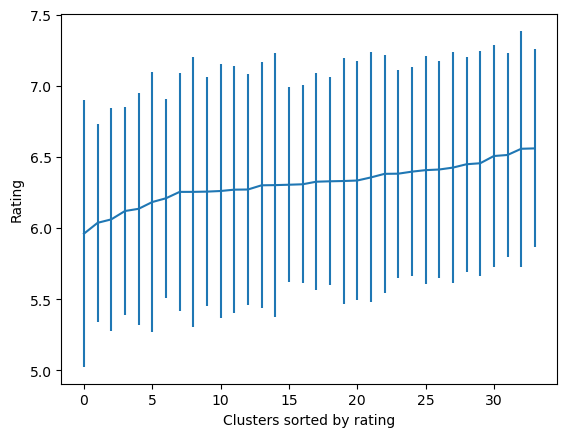

In [136]:
plt.errorbar(data = cluster_ratings_avg_std, x = cluster_ratings_avg_std.index, y = 'Rating_avg', yerr = 'Rating_std')
plt.xlabel("Clusters sorted by rating")
plt.ylabel("Rating")

Looking at this plot with all the clusters sorted by rating and the standard error of mean as error bars, we see that there is a difference in the rating for the 30 clusters, but it looks as if it is not significant. 

We need to find a method that can help us argue choosing a given k, and reevaluate the results. 

# Word2Vec

In [8]:
from gensim.models import Word2Vec

# Preprocess the summaries and word2vec
def preprocess_text_for_word2vec(text):
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Convert to lowercase and tokenize
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    return words

# Remove names form the summaries
nlp = spacy.load("en_core_web_sm")

def remove_names(text): 
    doc = nlp(text)
    filtered_text = []
    for token in doc:
        if token.ent_type_ != "PERSON":
            filtered_text.append(token.text)
    return " ".join(filtered_text)
# Preprocess the summaries for Word2Vec
preprocessed_summaries_for_word2vec = []
if flag_preprocess:
    for summary in tqdm(filtered_summaries, desc="Processing summaries for Word2Vec"):
        preprocessed_summaries_for_word2vec.append(preprocess_text_for_word2vec(remove_names(summary.split('\t')[1])))

    # Train Word2Vec model
    model = Word2Vec(sentences=preprocessed_summaries_for_word2vec, vector_size=100, window=5, min_count=1, workers=4)

    # Save the Word2Vec model
    model.save("word2vec_model")

Processing summaries for Word2Vec: 100%|██████████| 8674/8674 [12:59<00:00, 11.13it/s]


In [9]:
# Save preprocessed_summaries list to a file
with open('preprocessed_summaries_for_word2vec.pkl', 'wb') as file:
    pickle.dump(preprocessed_summaries_for_word2vec, file)

In [10]:
# Load preprocessed_summaries list from the saved file
with open('preprocessed_summaries_for_word2vec.pkl', 'rb') as file:
    preprocessed_summaries_for_word2vec = pickle.load(file)

In [16]:
# Load Word2Vec model
word2vec_model = Word2Vec.load("word2vec_model")

# Get the vector representation for each summary
word2vec_vectors = []
for summary in preprocessed_summaries_for_word2vec:
    summary_vector = np.mean([word2vec_model.wv[word] for word in summary if word in word2vec_model.wv], axis=0)
    word2vec_vectors.append(summary_vector)

# Convert Word2Vec vectors into a numpy array
word2vec_matrix = np.vstack(word2vec_vectors)
word2vec_matrix

array([[-0.10532889,  0.36231804,  0.14911422, ..., -0.4753856 ,
         0.02014627,  0.12097374],
       [-0.1270169 ,  0.09654351,  0.03474119, ..., -0.4219855 ,
         0.26349607,  0.19200888],
       [-0.00802298,  0.4580669 ,  0.38678354, ..., -0.5274362 ,
         0.02323777,  0.09361342],
       ...,
       [-0.05655876,  0.24518363,  0.20149295, ..., -0.59635025,
        -0.04546278,  0.17611596],
       [ 0.03118059,  0.23452447,  0.129098  , ..., -0.3081802 ,
         0.5413407 ,  0.20769957],
       [-0.06735189,  0.24578308,  0.38555312, ..., -0.47305638,
         0.24421307,  0.108387  ]], dtype=float32)

/Users/mathiaskroismoller/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


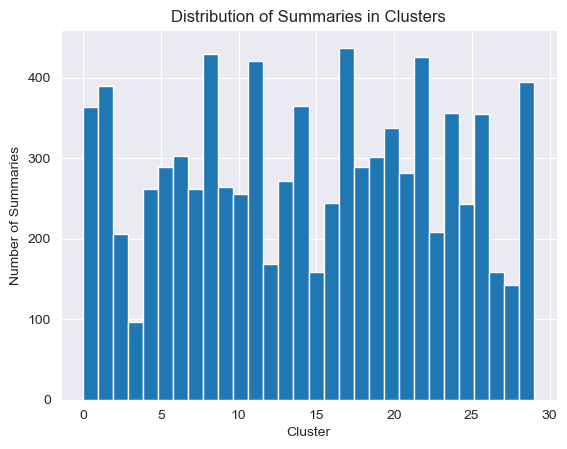

In [30]:
# Specify the number of clusters
num_clusters = 30  # You can adjust this based on your preference

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(word2vec_matrix)

# Add the cluster labels to your summaries
clustered_summaries = [{"id": movie_ids[i], "text": preprocessed_summaries_for_word2vec[i], "cluster": clusters[i]} for i in range(len(preprocessed_summaries_for_word2vec))]

# Visualize the distribution of clusters
plt.hist(clusters, bins=num_clusters, align='mid', rwidth=1)
plt.xlabel('Cluster')
plt.ylabel('Number of Summaries')
plt.title('Distribution of Summaries in Clusters')
plt.show()

In [61]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Function to get the most important words for each cluster
def get_most_important_words_per_cluster(clustered_summaries, word2vec_model, num_top_words=10):
    cluster_words = {}

    for cluster_id in range(num_clusters):
        # Extract summaries and text for the current cluster
        cluster_text = [summary['text'] for summary in clustered_summaries if summary['cluster'] == cluster_id]

        # Flatten the list of lists into a single list of words
        cluster_text_flat = [word for sublist in cluster_text for word in sublist]

        # Combine all summaries into a single string for the cluster
        cluster_combined_text = ' '.join(cluster_text_flat)

        # Vectorize the cluster text using CountVectorizer
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([cluster_combined_text])

        # Get feature names (words) and their counts
        feature_names = vectorizer.get_feature_names_out()
        word_counts = X.toarray()[0]

        # Create a DataFrame with words and their counts
        word_count_df = pd.DataFrame({'word': feature_names, 'count': word_counts})

        # Sort the DataFrame by count in descending order
        word_count_df = word_count_df.sort_values(by='count', ascending=False)

        # Select the top N words for the cluster
        top_words = word_count_df.head(num_top_words)['word'].tolist()

        # Save the top words for the cluster
        cluster_words[cluster_id] = top_words

    return cluster_words

# Get the most important words for each cluster
cluster_words = get_most_important_words_per_cluster(clustered_summaries, word2vec_model)

# Create a DataFrame from the cluster_words dictionary
df_cluster_words = pd.DataFrame.from_dict(cluster_words, orient='index').transpose()

# Display the DataFrame
df_cluster_words

ValueError: empty vocabulary; perhaps the documents only contain stop words

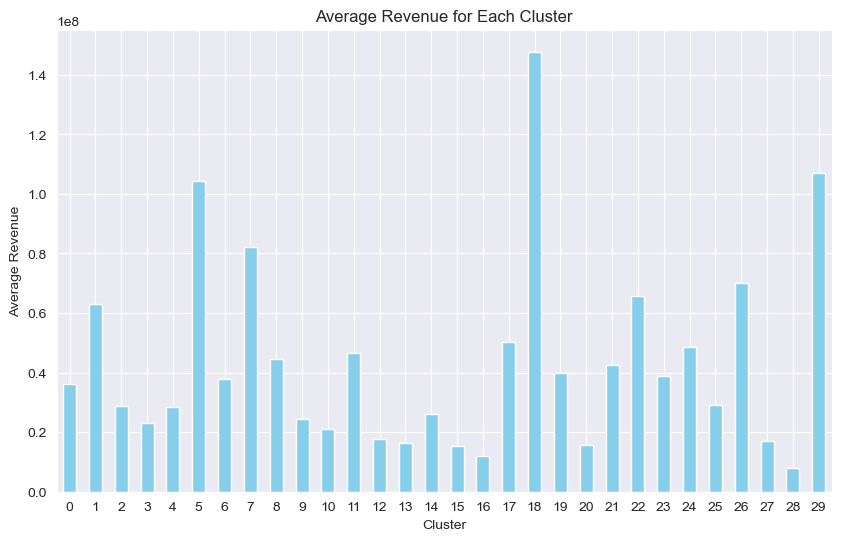

In [33]:
import matplotlib.pyplot as plt

# Add the revenue information to your summaries
for summary in clustered_summaries:
    movie_id = summary['id']
    revenue = movie_metadata.loc[movie_metadata['Wikipedia Movie ID'] == movie_id, 'Movie box office revenue enriched'].values
    summary['revenue'] = revenue[0] if len(revenue) > 0 else None

# Create a DataFrame from the clustered summaries
clustered_df = pd.DataFrame(clustered_summaries)

# Group the DataFrame by cluster and calculate the average revenue for each cluster
average_revenue_per_cluster = clustered_df.groupby('cluster')['revenue'].mean()

# Plot the average revenue for each cluster
plt.figure(figsize=(10, 6))
average_revenue_per_cluster.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average Revenue')
plt.title('Average Revenue for Each Cluster')
plt.xticks(rotation=0)
plt.show()

/var/folders/z6/0dqw2m7n37l5vjqcv_822tdr0000gn/T/ipykernel_33365/4119194214.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='cluster', y='revenue', data=clustered_df, ci="sd", capsize=0.2, color='skyblue')
/Users/mathiaskroismoller/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathiaskroismoller/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathiaskroismoller/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and 

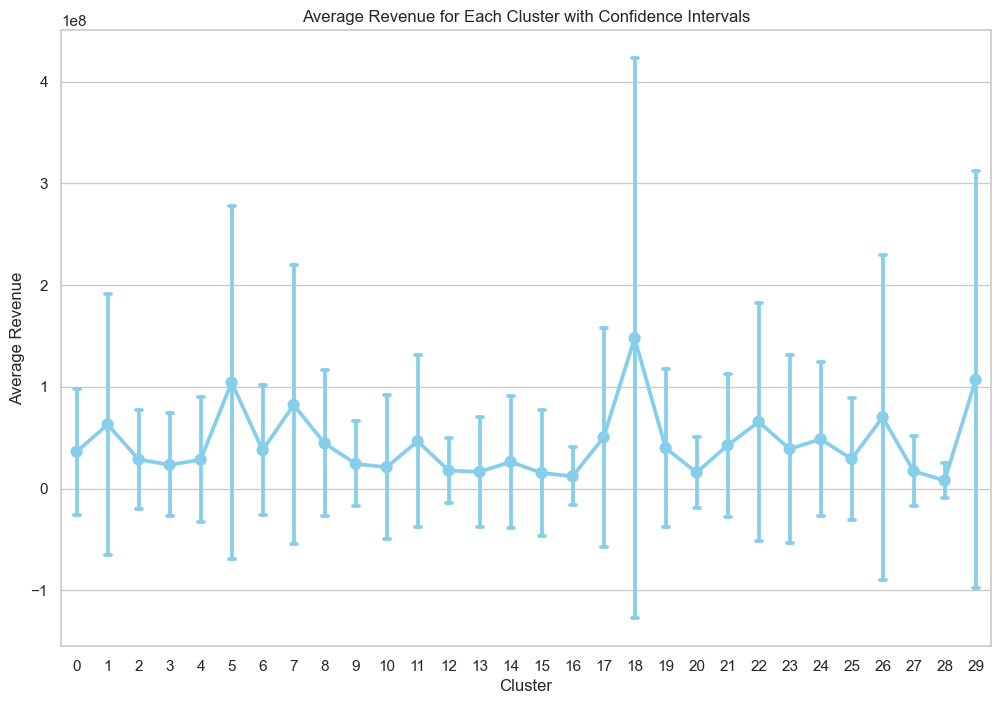

In [35]:
import seaborn as sns

# Set the style for the plot
sns.set(style="whitegrid")

# Plot the point plot with confidence intervals
plt.figure(figsize=(12, 8))
sns.pointplot(x='cluster', y='revenue', data=clustered_df, ci="sd", capsize=0.2, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average Revenue')
plt.title('Average Revenue for Each Cluster with Confidence Intervals')
plt.show()



/var/folders/z6/0dqw2m7n37l5vjqcv_822tdr0000gn/T/ipykernel_33365/1803836373.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='cluster', y='revenue', data=clustered_df, ci="sd", capsize=0.2, color='skyblue', order=sorted_clusters)
/Users/mathiaskroismoller/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathiaskroismoller/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


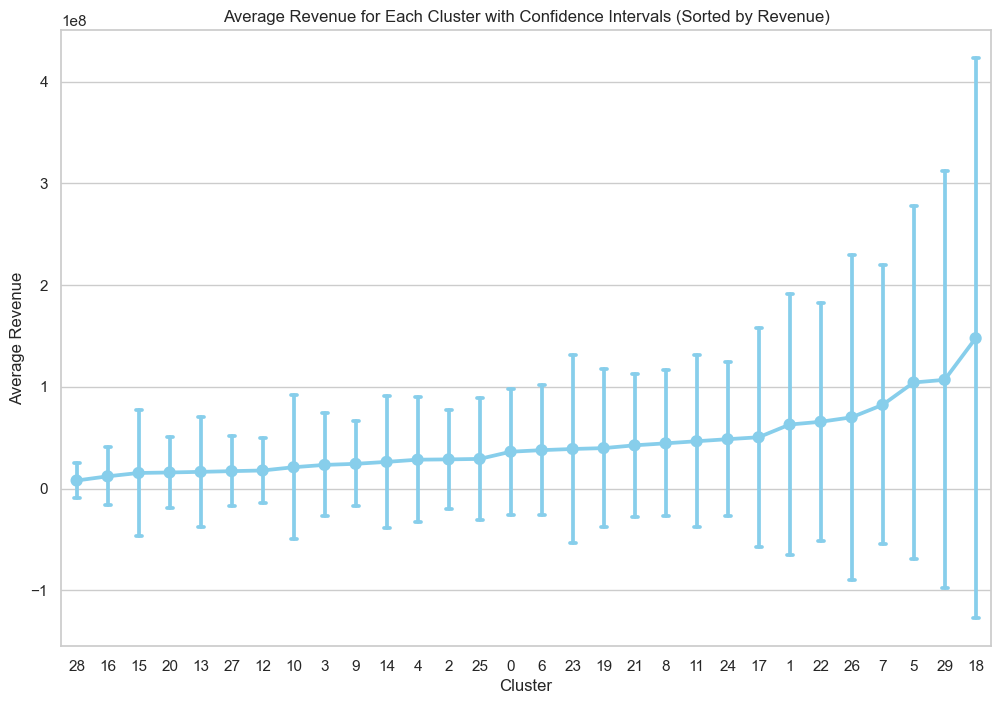

In [37]:
import seaborn as sns

# Calculate the average revenue for each cluster
average_revenue_per_cluster = clustered_df.groupby('cluster')['revenue'].mean()

# Sort clusters based on average revenue
sorted_clusters = average_revenue_per_cluster.sort_values().index

# Set the style for the plot
sns.set(style="whitegrid")

# Plot the point plot with confidence intervals
plt.figure(figsize=(12, 8))
sns.pointplot(x='cluster', y='revenue', data=clustered_df, ci="sd", capsize=0.2, color='skyblue', order=sorted_clusters)
plt.xlabel('Cluster')
plt.ylabel('Average Revenue')
plt.title('Average Revenue for Each Cluster with Confidence Intervals (Sorted by Revenue)')
plt.show()
